In [3]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [4]:
# Load Dataset
df = pd.read_csv("df_file.csv")
df.head()


,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0


In [5]:
import kagglehub
import os

# Download dataset
path = kagglehub.dataset_download("sunilthite/text-document-classification-dataset")

print("Path to dataset files:", path)
files = os.listdir(path)
print("Files in dataset:", files)

# Assuming 'df_file.csv' is the file we need
csv_path = os.path.join(path, 'df_file.csv')
print(f"Using CSV at: {csv_path}")

Path to dataset files: /home/akash/.cache/kagglehub/datasets/sunilthite/text-document-classification-dataset/versions/1
Files in dataset: ['df_file.csv']
Using CSV at: /home/akash/.cache/kagglehub/datasets/sunilthite/text-document-classification-dataset/versions/1/df_file.csv


In [6]:
# Load Dataset using the kagglehub path
df = pd.read_csv(csv_path)
display(df.head())

,Text,Label
0,Budget to set scene for election\n \n Gordon B...,0
1,Army chiefs in regiments decision\n \n Militar...,0
2,Howard denies split over ID cards\n \n Michael...,0
3,Observers to monitor UK election\n \n Minister...,0
4,Kilroy names election seat target\n \n Ex-chat...,0


In [7]:
# Keep only Politics and sports

label_map = {0: "Politics", 1: "Sports"}

df = df[df["Label"].isin([0, 1])]
df["Label"] = df["Label"].map(label_map)

df["Label"].value_counts()


Label
Sports      511
Politics    417
Name: count, dtype: int64

In [8]:
# basic cleaning

df.dropna(subset=["Text"], inplace=True)
df["Text"] = df["Text"].astype(str)
df = df[df["Text"].str.strip() != ""]


In [9]:
# text preprocessing

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["Text"].apply(clean_text)


In [10]:
# feature Fngineering
df["word_count"] = df["clean_text"].apply(lambda x: len(x.split()))
df["char_count"] = df["clean_text"].apply(len)


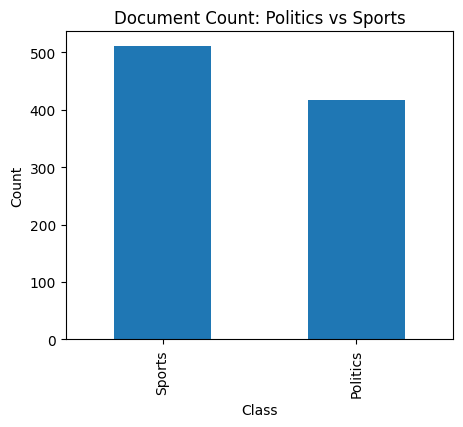

In [11]:
# class distribution
df["Label"].value_counts().plot(kind="bar", figsize=(5,4))
plt.title("Document Count: Politics vs Sports")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


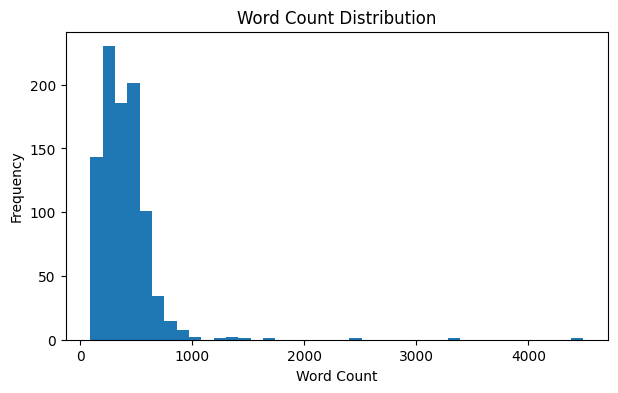

In [12]:
# word count

plt.figure(figsize=(7,4))
plt.hist(df["word_count"], bins=40)
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Word Count Distribution")
plt.show()


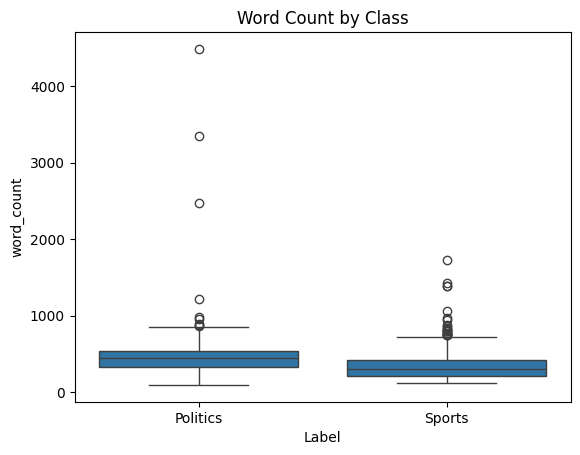

In [13]:
# word count by class

sns.boxplot(x="Label", y="word_count", data=df)
plt.title("Word Count by Class")
plt.show()


In [14]:
# top unigrams

from sklearn.feature_extraction.text import CountVectorizer

def top_ngrams(texts, ngram_range=(1,1), top_n=20):
    vec = CountVectorizer(
        stop_words="english",
        ngram_range=ngram_range
    )
    X = vec.fit_transform(texts)
    freqs = X.sum(axis=0)

    words = [
        (w, freqs[0, i])
        for w, i in vec.vocabulary_.items()
    ]

    return sorted(words, key=lambda x: x[1], reverse=True)[:top_n]


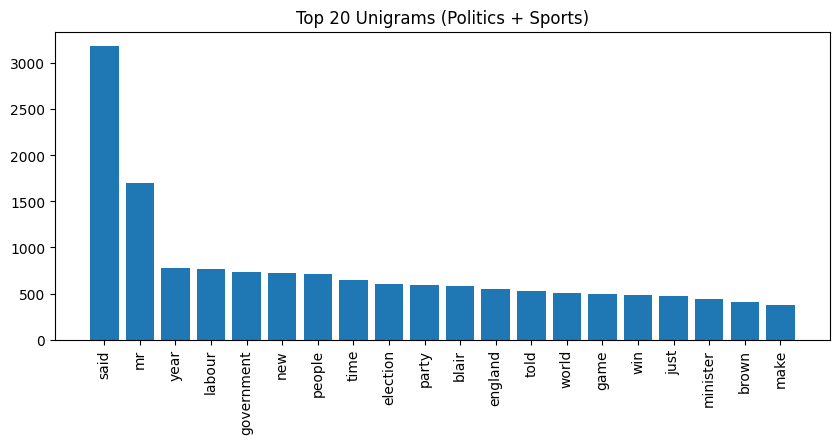

In [15]:
uni = top_ngrams(df["clean_text"], (1,1))
words, counts = zip(*uni)

plt.figure(figsize=(10,4))
plt.bar(words, counts)
plt.xticks(rotation=90)
plt.title("Top 20 Unigrams (Politics + Sports)")
plt.show()


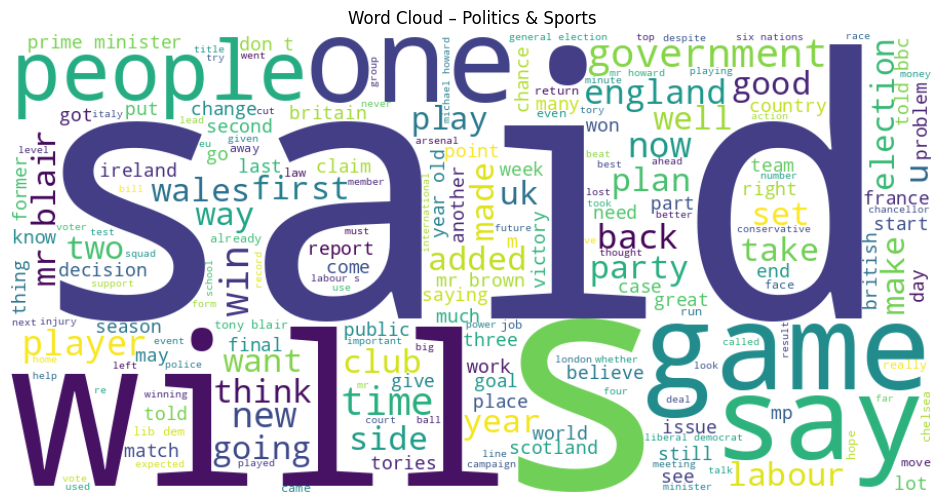

In [16]:
# word cloud

text_all = " ".join(df["clean_text"].values)

wc_all = WordCloud(
    width=900,
    height=450,
    background_color="white",
    stopwords=STOPWORDS,
    max_words=200
)

plt.figure(figsize=(12,6))
plt.imshow(wc_all.generate(text_all), interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – Politics & Sports")
plt.show()


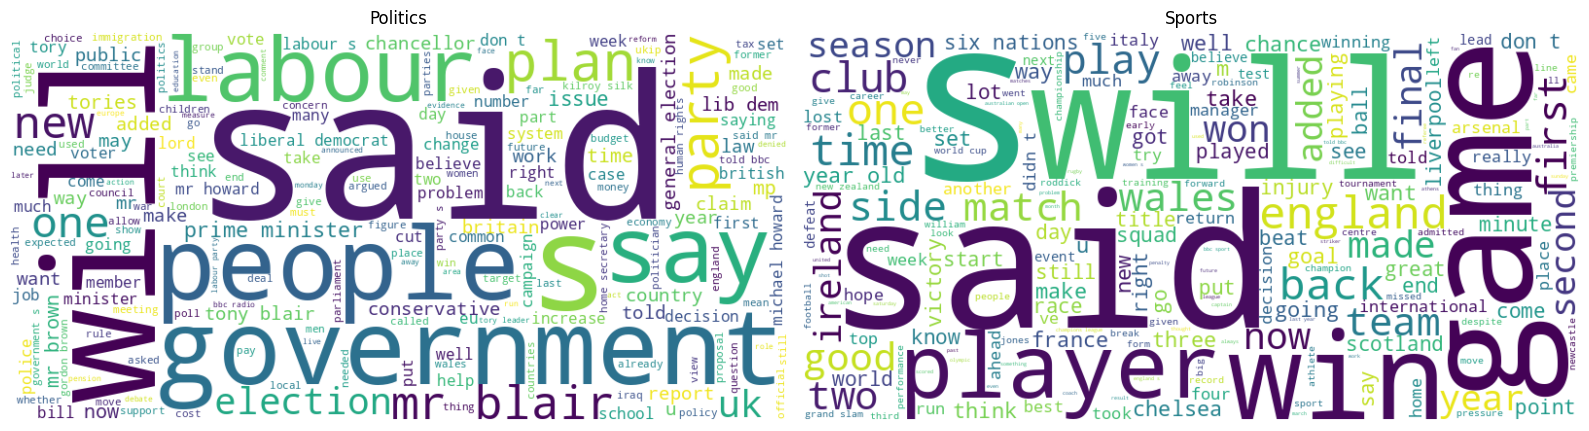

In [17]:
wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=STOPWORDS,
    max_words=200,
    colormap="viridis"
)

politics_text = " ".join(
    df[df["Label"] == "Politics"]["clean_text"].values
)

sports_text = " ".join(
    df[df["Label"] == "Sports"]["clean_text"].values
)

wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    stopwords=STOPWORDS,
    max_words=200
)

plt.figure(figsize=(16,6))

# Politics
plt.subplot(1, 2, 1)
plt.imshow(wc.generate(politics_text), interpolation="bilinear")
plt.title("Politics")
plt.axis("off")

# Sports
plt.subplot(1, 2, 2)
plt.imshow(wc.generate(sports_text), interpolation="bilinear")
plt.title("Sports")
plt.axis("off")

plt.tight_layout()
plt.show()


In [18]:
# text clasification
X = df["clean_text"]
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [19]:
# feature representation tf-idf

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [20]:
# model 1 - naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

y_pred_nb = nb.predict(X_test_tfidf)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 1.0
              precision    recall  f1-score   support

    Politics       1.00      1.00      1.00        84
      Sports       1.00      1.00      1.00       102

    accuracy                           1.00       186
   macro avg       1.00      1.00      1.00       186
weighted avg       1.00      1.00      1.00       186



In [21]:
# model 2 - random forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.978494623655914
              precision    recall  f1-score   support

    Politics       0.99      0.96      0.98        84
      Sports       0.97      0.99      0.98       102

    accuracy                           0.98       186
   macro avg       0.98      0.98      0.98       186
weighted avg       0.98      0.98      0.98       186



In [22]:
# Svm

from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

y_pred_svm = svm.predict(X_test_tfidf)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 1.0
              precision    recall  f1-score   support

    Politics       1.00      1.00      1.00        84
      Sports       1.00      1.00      1.00       102

    accuracy                           1.00       186
   macro avg       1.00      1.00      1.00       186
weighted avg       1.00      1.00      1.00       186



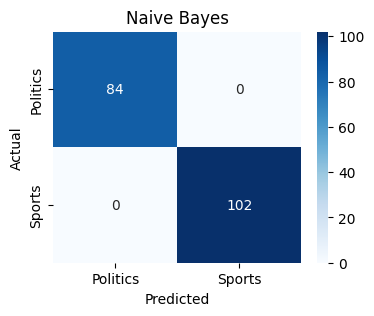

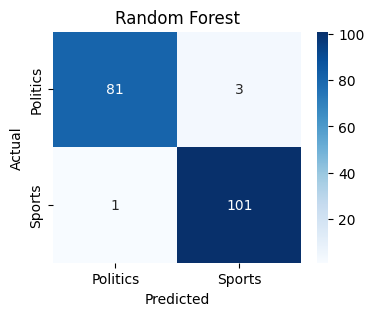

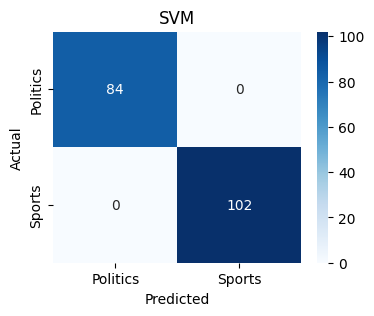

In [23]:
# confusion matrix
from sklearn.metrics import confusion_matrix

models = {
    "Naive Bayes": y_pred_nb,
    "Random Forest": y_pred_rf,
    "SVM": y_pred_svm
}

for name, preds in models.items():
    plt.figure(figsize=(4,3))
    sns.heatmap(
        confusion_matrix(y_test, preds),
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Politics","Sports"],
        yticklabels=["Politics","Sports"]
    )
    plt.title(name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
